# SCADAA Coursework

### Team:
* Ananya Jaishankar (s2538071) - $\frac{1}{3}$

* Frances McKnight (s2535018) - $\frac{1}{3}$

* Luz Pascual (s2571924) - $\frac{1}{3}$

In [2]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import odeint, solve_ivp, quad
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.utils as torch_utils

from DGM import DGM_Layer, Net_DGM
from FFN import FFN


## Exercise 1.1

In [64]:
class LQR:
    def __init__(self, H, M, sigma, C, D, R, T) -> None:
        self.H = H 
        self.M = M
        self.sigma = sigma
        self.C = C 
        self.D = D 
        self.R = R
        self.T = T
    

    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat, dtype=torch.float32).reshape((2, 2))  # Convert S_flat to a PyTorch tensor
        dS = (-2 * (self.H.t() @ S) + S @ (self.M) @ (torch.inverse(self.D)) @ (np.transpose(self.M)) @ S - self.C)
        return dS.flatten().detach().numpy()
 

    def solve_ricatti_ode(self, time_grid):
        """
        Solves the LQR problem by integrating the 
        Riccati equation backwards in time.
        """
        # Time points (reversed for backward integration)
        # t_points = np.linspace(0, self.T, 1000)[::-1]  
        intial_cond = self.R.flatten().detach().numpy()

        sol = solve_ivp(
            self.riccati_ode, [self.T.item(), time_grid[0].item()], 
            intial_cond, t_eval=time_grid.numpy()[::-1], method='RK45'
            )
        
        S = torch.tensor(sol.y)

        return S

    def visualize_results(self, t_points, S):
        """
        Visualizes the solution of the Riccati equation 
        or the state/control trajectories.
        """
        # S_00 = [s[0, 0].item() for s in S]
        plt.plot(t_points, S[0, :])
        plt.xlabel('Time')
        plt.ylabel('S[0,0]')
        plt.title('Solution of Riccati Equation over Time')
        plt.show()
       

    def markov_control(self, t_batch, x_batch):
        a=torch.tensor([])
        for t in range(len(t_batch)):
            time_grid = torch.linspace(float(t_batch[t]), self.T, 1000, dtype=torch.float32)
            S = self.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float()
            S_ordered =torch.flip(S,dims=[0])
            x_batch_n = x_batch[t]
            a_ = -((torch.inverse(self.D.float()) @ self.M.T) @ S_ordered[0]) @ x_batch_n.T
            a=torch.cat((a,a_.unsqueeze(0))) 
        return a.transpose(1,2)


    def value_function(self, t_batch, x_batch):
        v=torch.tensor([])
        for t in range(len(t_batch)):
            time_grid = torch.linspace(float(t_batch[t]), self.T, 1000, dtype=torch.float32)
            S = self.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float()
            S_ordered =torch.flip(S,dims=[0])
            sigma = self.sigma
            x_batch_n = x_batch[t]

            # Compute the first term: x.transpose(S)x
            x_S_x = torch.matmul(torch.matmul(x_batch_n.unsqueeze(0), S_ordered[0]), x_batch_n.unsqueeze(0).transpose(-1, -2)).squeeze()

        # Compute the integral term using Einstein summation notation with smaller time steps
            integral_term = 0
            for i in range(len(time_grid) - 1):
                dt = time_grid[i + 1] - time_grid[i]
                int_term=sigma@sigma.T@S_ordered[i]
                trace_term = torch.einsum('bij->b',int_term.unsqueeze(0))
                integral_term += trace_term * dt

            # Compute the total value function: v(t, x) = x.transpose(S)x + trace_term
            v=torch.cat((v,x_S_x + integral_term)) 
        return v


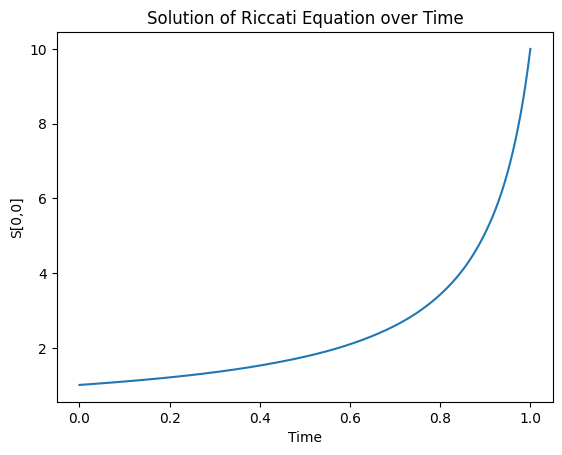

Optimal Markov Control:
tensor([[[-2.5995, -2.5995]]])
Value Function:
tensor([5.1990])


In [65]:
# Example Usage:

#Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.1
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.001
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(1.0, dtype=torch.float32)
x0 = torch.tensor([1, 1], dtype=torch.float32)
t=torch.tensor(0.7, dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*10

# Define time grid
time_grid = torch.linspace(0, T, 10000)

lqr_system = LQR(H, M, sigma, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid)
S_sol_v2 = S_solution.T.reshape(len(time_grid),2,2)
S_sol_ordered =torch.flip(S_sol_v2,dims=[0])
lqr_system.visualize_results(torch.flip(time_grid, [0]), S_solution)

t_batch = torch.tensor([0.7], dtype=torch.float32)  # Sample time values
x_batch = torch.tensor([
    [[1.0, 1.0]] 
], dtype=torch.float32)  # Sample spatial values

# Compute the markov control
markov_control = lqr_system.markov_control(t_batch, x_batch)

# Print the computed value function
print("Optimal Markov Control:")
print(markov_control)

# Compute the value function
value_func = lqr_system.value_function(t_batch, x_batch)

# Print the computed value function
print("Value Function:")
print(value_func)

## Exercise 1.2

In [66]:
# Create error function 
def calculate_error(X1, X2):
    error = (1/len(X1))*(X1-X2)^2
    return error

In [67]:
#Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.1
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.001
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(1.0, dtype=torch.float32)
x0 = torch.tensor([1, 1], dtype=torch.float32)
t=torch.tensor(0.7, dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*10

# Define time grid
time_grid_S = torch.linspace(0, T, 10000)
lqr_system = LQR(H, M, sigma, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid_S)
S_sol_v2 = S_solution.T.reshape(len(time_grid_S),2,2).float()
S_sol_ordered =torch.flip(S_sol_v2,dims=[0])

# Code for spline on tbatch
gen_s_spline = PchipInterpolator((time_grid_S).numpy(), S_sol_ordered)


In [68]:
# X Generation
def generate_x(T, N_steps, H, M, D, S_solution, sigma, x0):

    x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1) 
    tau = T / N_steps
    X = x0.unsqueeze(0)
    brownian = torch.randn(N_steps, 2, dtype=torch.float32)*torch.sqrt(tau)

    for i in range(N_steps-1):
        dw = (brownian[i+1] - brownian[i]).view(2, 1)  # Ensure dw is a 2x1 vector
        # Calculate control action, ensuring it results in a 2x1 vector
        a_s = -torch.inverse(D.float()) @ M.T @ S_sol_ordered.float()[i] @ X[-1]
        # Update state, ensuring result is a 2x1 vector
        next_val = X[-1] + tau * (H @ X[-1] + M @ a_s) + sigma @ dw  # Use matrix-vector product for sigma @ dw
        
        X=torch.cat((X,next_val.view(2, 1).unsqueeze(0))) # Ensure next_val remains a 2x1 column vector

    return X.transpose(1,2)

# Call the function with corrected inputs
N_steps = 100
result = generate_x(T, N_steps, H.float(), M.float(), D.float(), S_solution.float(), sigma.float(), x0)
print(result)

tensor([[[1.0000, 1.0000]],

        [[0.9908, 0.9910]],

        [[0.9817, 0.9818]],

        [[0.9728, 0.9730]],

        [[0.9639, 0.9640]],

        [[0.9551, 0.9552]],

        [[0.9464, 0.9464]],

        [[0.9376, 0.9378]],

        [[0.9290, 0.9291]],

        [[0.9204, 0.9207]],

        [[0.9121, 0.9123]],

        [[0.9038, 0.9037]],

        [[0.8955, 0.8956]],

        [[0.8874, 0.8875]],

        [[0.8790, 0.8793]],

        [[0.8712, 0.8714]],

        [[0.8633, 0.8632]],

        [[0.8552, 0.8552]],

        [[0.8474, 0.8475]],

        [[0.8396, 0.8398]],

        [[0.8321, 0.8322]],

        [[0.8244, 0.8243]],

        [[0.8167, 0.8168]],

        [[0.8093, 0.8094]],

        [[0.8018, 0.8020]],

        [[0.7944, 0.7946]],

        [[0.7872, 0.7874]],

        [[0.7800, 0.7798]],

        [[0.7729, 0.7730]],

        [[0.7658, 0.7658]],

        [[0.7588, 0.7589]],

        [[0.7517, 0.7519]],

        [[0.7450, 0.7451]],

        [[0.7381, 0.7382]],

        [[0.73

/tmp/ipykernel_1868/1575109474.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


### Exercise 1.2.2

In [69]:
N_samples = 10 #CHANGE FOR LOCAL RUNNING
N_steps = [1, 10, 50, 100, 500, 1000, 5000]
cost = torch.tensor([])
exp_cost = torch.tensor([])

for t in range(len(N_steps)):
    for k in range(len(t_batch)):
        time_grid = torch.linspace(t_batch[k], T, N_steps[t]+1)
        S_sol_cs = gen_s_spline(time_grid)
        dt= time_grid[1:]-time_grid[:-1]
        S_sol_cs_vals = torch.tensor(S_sol_cs,dtype=torch.float32)

        for i in range(N_samples):
            result = generate_x(T, N_steps[t]+1, H.float(), M.float(), D.float(), 
                                S_sol_cs_vals.float(), sigma.float(), x0)
            alp = (-torch.inverse(D) @ M.T @ S_sol_cs_vals @result.transpose(1,2)).transpose(1,2)
            int_ = result@C@result.transpose(1,2) + alp@D@alp.transpose(1,2)
            J = torch.tensor(0.5)*dt@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))
            cost = torch.cat((cost,J))

    exp_cost=torch.cat((exp_cost,torch.mean(cost).unsqueeze(0)))

/tmp/ipykernel_1868/1575109474.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


KeyboardInterrupt: 

In [9]:
def calculate_mse(X1, X2):
    count = 0
    MSE = []
    SE = 0

    for i in range(len(X2)):
        SE += (X2.data[i] - X1)**2
        count += 1
    return SE/count

# Compute the error
error = abs(exp_cost-value_func)
print(error) 
#Plot the error
plt.loglog(N_steps, error, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale')
plt.grid(True, which="both", ls="--")
plt.show()

tensor([638.7959, 161.9492,  69.0262,  37.0251,  22.3398,  14.4481,   8.9660])


NameError: name 'error' is not defined

Exercise 1.2.3

In [70]:
#N_samples=[10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
N_samples = [10, 50, 100, 500, 1000, 5000, 10000]
N_steps = 5000
cost_samples = torch.tensor([])
exp_cost_samples = torch.tensor([])

# Time grid specifications
time_grid = torch.linspace(0, T, N_steps+1)
dt = time_grid[1:]-time_grid[:-1]
S_sol_cs = gen_s_spline(time_grid)
S_sol_cs_vals = torch.tensor(S_sol_cs,dtype=torch.float32)

for j in range(len(N_samples)):
    print(f"Running with {N_samples[j]} samples")
    for i in range(N_samples[j]):
        result = generate_x(T, N_steps+1, H.float(), M.float(), D.float(), 
        S_sol_cs_vals.float(), sigma.float(), x0)

        alp = (-torch.inverse(D) @ M.T @ S_sol_cs_vals @result.transpose(1,2)).transpose(1,2)
        int_ = result@C@result.transpose(1,2) + alp@D@alp.transpose(1,2)

        J = result[-1]@R@result[-1].T + torch.tensor(0.5)*dt@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))
        cost_samples=torch.cat((cost_samples,J))

    exp_cost_samples=torch.cat((exp_cost_samples,torch.mean(cost_samples).unsqueeze(0)))

Running with 10 samples


/tmp/ipykernel_1868/1575109474.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


KeyboardInterrupt: 

tensor([5.1072, 5.1072, 5.1072, 5.1072, 5.1072, 5.1072, 5.1072])


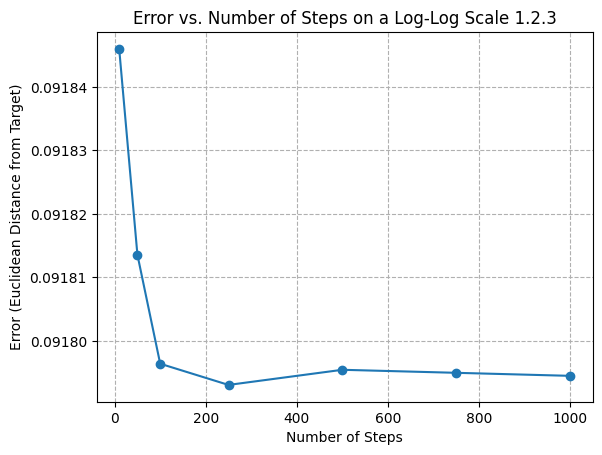

In [ ]:
# Compute the error
error_samples = abs(exp_cost_samples - value_func)
print(error_samples)

#Plot the error
plt.plot(N_samples, error_samples, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale')
plt.grid(True, which="both", ls="--")
plt.show()

## Exercise 2

### Exercise 2.1

In [33]:
# Function to generate training data
def generate_training_data(T, num_samples):
    t = torch.tensor(np.random.uniform(0, T, num_samples), dtype=torch.float32)
    x = torch.tensor(np.random.uniform(-3, 3, (num_samples, 2)), dtype=torch.float32).unsqueeze(-1).transpose(1,2)
    return t, x

In [21]:
def train_net_dgm(net_dgm, t_train, x_train, epochs=1000, lr=1e-2):
    """
    Function to train a neural network `net_dgm` for value function 
    prediction using training data `t_train` and `x_train`.

    Args:
        net_dgm (torch.nn.Module): The neural network model to train.
        t_train (torch.Tensor): Input time data tensor.
        x_train (torch.Tensor): Input state data tensor.
        epochs (int): Number of training epochs.
        lr (float): Initial learning rate.

    Returns:
        losses (np.array): Array of loss values during training.
    """
    # Initialize optimizer, criterion, and an empty array to store loss values
    optimizer = optim.Adam(net_dgm.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = np.array([])

    # Learning rate scheduler: Reduce learning rate by a factor of 0.2 every 100 epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute the real value function based on training data
        v_real = lqr_system.value_function(t_train, x_train).unsqueeze(1)

        # Forward pass: Predict value function using the neural network
        v_pred = net_dgm(t_train.unsqueeze(1), x_train.view(-1, 2))  # Adjust input shape if necessary

        # Compute the loss between predicted and real value functions
        loss = criterion(v_pred, v_real)

        # Backpropagation: Compute gradients and update model parameters
        loss.backward()
        optimizer.step()

        # Append the current loss value to the losses array
        losses = np.append(losses, loss.item())

        # Update learning rate based on the scheduler
        scheduler.step()

        # Print the loss value every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses


In [28]:
# Generate training data
T = 1.0
num_samples = 100
t_train, x_train = generate_training_data(T, num_samples)

# Initialize the neural network
net_dgm = Net_DGM(dim_x=2, dim_S=100, hidden_size=100)

# Train the neural network with hyperparameter scheduling
losses = train_net_dgm(net_dgm, t_train, x_train, epochs=1000, lr=1e-2)


Epoch 0, Loss: 159.58963012695312
Epoch 100, Loss: 3.473514880170114e-05
Epoch 200, Loss: 4.630749117495725e-10
Epoch 300, Loss: 5.741185521782044e-13
Epoch 400, Loss: 1.1368683941568192e-14


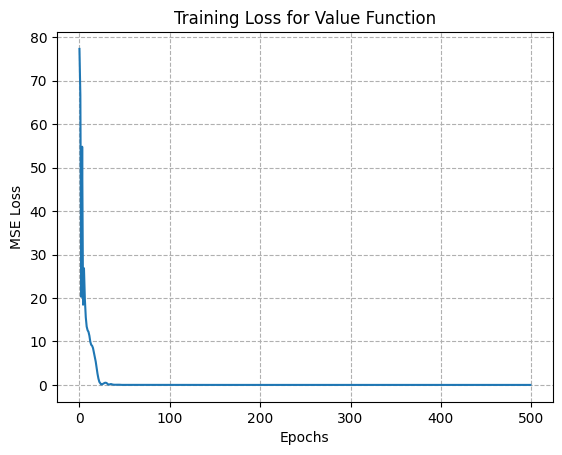

In [54]:
# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss for Value Function')
plt.grid(ls='--')
plt.show()

### Exercise 2.2

In [10]:
def train_ffn_net(net_ffn, t_train, x_train, epochs=1000, lr=1e-2):
    """
    Function to train a feedforward neural network `net_ffn` for Markov 
    control prediction using training data `t_train` and `x_train`.

    Args:
        net_ffn (torch.nn.Module): The feedforward neural network model to train.
        t_train (torch.Tensor): Input time data tensor.
        x_train (torch.Tensor): Input state data tensor.
        epochs (int): Number of training epochs.
        lr (float): Initial learning rate.

    Returns:
        losses (list): List of loss values during training.
    """
    # Initialize optimizer, concatenate time and state tensors for input to the network
    optimizer = optim.Adam(net_ffn.parameters(), lr=lr)
    tx_train = torch.cat((t_train.unsqueeze(1), x_train.squeeze(1)), dim=1)
    criterion = nn.MSELoss()

    # Initialize an empty list to store loss values
    losses = []

    # Learning rate scheduler: Reduce learning rate by a factor of 0.2 every 100 epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute the real Markov control based on training data
        a_real = lqr_system.markov_control(t_train, x_train).squeeze(1)

        # Forward pass: Predict Markov control using the neural network
        input_data = torch.cat((t_train.unsqueeze(1), x_train.view(-1, 2)), dim=1)
        a_pred = net_ffn(input_data)

        # Compute the loss between predicted and real Markov control
        loss = criterion(a_pred, a_real)

        # Backpropagation: Compute gradients and update model parameters
        loss.backward()
        optimizer.step()

        # Append the current loss value to the losses list
        losses.append(loss.item())

        # Update learning rate based on the scheduler
        scheduler.step()

        # Print the loss value every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses


In [17]:
# Generate training data
T = 1
num_samples = 100
t_train, x_train = generate_training_data(T, num_samples)

# Define the sizes for the FFN network
sizes = [3, 150, 150, 2]  

# Initialize the feedforward neural network
net_ffn = FFN(sizes)

# Train the feedforward neural network with hyperparameter scheduling
losses = train_ffn_net(net_ffn, t_train, x_train, epochs=1000, lr=1e-2)


Epoch 0, Loss: 19.613569259643555


Epoch 100, Loss: 9.910670632962137e-05
Epoch 200, Loss: 5.123593993516806e-08
Epoch 300, Loss: 2.2971825330841966e-08
Epoch 400, Loss: 1.9595962186258475e-08
Epoch 500, Loss: 1.909163316327067e-08
Epoch 600, Loss: 1.9049064547971284e-08
Epoch 700, Loss: 1.9050606425707883e-08
Epoch 800, Loss: 1.9050606425707883e-08
Epoch 900, Loss: 1.9050606425707883e-08


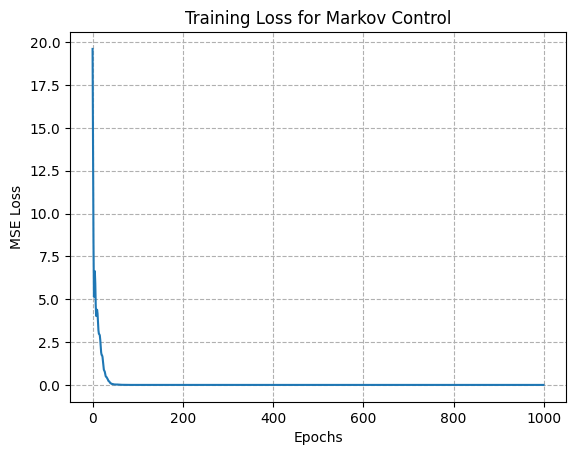

In [19]:
# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss for Markov Control')
plt.grid(ls='--')
plt.show()

In [32]:
a_real = lqr_system.markov_control(t_train, x_train).squeeze(1)
tx_train = torch.cat((t_train.unsqueeze(1),x_train.squeeze(1)),dim=1)
a_real, tx_train

(tensor([[ -5.3899,  -3.6218],
         [  3.8210,  -4.3507],
         [  1.4462,   2.4959],
         [ -1.2966,  -3.6192],
         [ 14.8546,   5.4911],
         [  1.4297,  -3.0257],
         [ -2.0395,  -3.1993],
         [  2.0472,   2.3622],
         [  1.8298,  -0.4494],
         [ -2.2903,  -1.8342],
         [  1.6151,  -2.3812],
         [ -0.5521,   5.1361],
         [  1.8511,   3.7150],
         [ -2.3856,  -3.7102],
         [  3.3821,   0.5171],
         [  3.0344,  -1.9264],
         [ -3.6519,  -2.7534],
         [ -0.3714,  -1.8003],
         [ -2.1395,   2.7550],
         [  1.1627,   1.1726],
         [ 12.8748,   7.4131],
         [  4.9515,   4.1822],
         [  1.3705,  -2.7848],
         [  3.1828,   4.1653],
         [  4.3796,  -3.7190],
         [ -4.2253,   0.2870],
         [ -6.7320,   0.7381],
         [  4.3615,   4.0955],
         [ -5.5785,  -1.0459],
         [-10.1026,   1.7270],
         [ 10.3573,   9.4130],
         [  0.8430,  -2.5381],
        

## Exercise 3

In [29]:
class PDE:
    def __init__(self, net, T, sigma, H, M, C, D, R, alpha):
        """
        Initialize the Partial Differential Equation (PDE) parameters.

        Args:
        - net: Neural network representing the solution function u(t, x)
        - T (torch.Tensor): Terminal time
        - sigma (torch.Tensor): State noise matrix
        - H (torch.Tensor): Quadratic term for state cost
        - M (torch.Tensor): Linear term for control cost
        - C (torch.Tensor): Quadratic term for control cost
        - D (torch.Tensor): Control cost matrix
        - R (torch.Tensor): Terminal cost matrix
        - alpha (torch.Tensor): Control input (action) vector
        """
        self.net = net
        self.T = T
        self.sigma = sigma
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.alpha = alpha
    
    def pde_residual(self, t, x):
        """
        Compute the residual of the PDE.

        Args:
        - t (torch.Tensor): Time variable
        - x (torch.Tensor): State variable

        Returns:
        - pde_res (torch.Tensor): PDE residual
        """
        t.requires_grad_(True)
        x.requires_grad_(True)
        
        # Evaluate the neural network u(t, x)
        u = self.net(t, x)  
        
        # Compute gradients
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Compute PDE terms
        trace_term = 0.5 * torch.trace(torch.matmul(self.sigma, self.sigma.T)) * u_xx.sum(dim=1, keepdim=True)  # (batch, 1)
        t1 = (u_x @ self.H @ x.T).sum(dim=1).unsqueeze(1)
        t2 = (torch.matmul(u_x, torch.matmul(self.M, self.alpha.T))).T.unsqueeze(1)
        x = x.unsqueeze(1).detach()
        t3 = torch.matmul(x, torch.matmul(self.C, x.reshape(num_samples, 2, 1))).reshape(num_samples, 1)
        t4 = torch.matmul(self.alpha.T, torch.matmul(self.D, self.alpha)).expand_as(trace_term)

        # Compute the PDE residual
        pde_res = u_t + trace_term + t1 + t2 + t3 + t4

        return pde_res

    def boundary_condition(self, x):
        """
        Compute the boundary condition of the PDE.

        Args:
        - x (torch.Tensor): State variable

        Returns:
        - boundary_cond (torch.Tensor): Boundary condition term
        """
        # Create a tensor of the same size as x with values T
        T = torch.full_like(x[:, :1], self.T.item())  
        
        # Evaluate the neural network u(T, x)
        u_final = self.net(T, x)  
        
        # Compute the boundary condition term
        x = x.unsqueeze(1).detach()
        cond = torch.matmul(x, torch.matmul(self.R, x.reshape(num_samples, 2, 1))).reshape(num_samples, 1)        
        return u_final - cond


In [43]:
class DGM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Deep Galerkin Model (DGM) for solving PDEs.

        Args:
            input_dim (int): Dimension of input (t + x).
            hidden_dim (int): Dimension of hidden layers.
            output_dim (int): Dimension of the output.

        """
        super(DGM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim) 
        self.activation = nn.Tanh()

    def forward(self, t, x):
        """
        Forward pass of the DGM.

        Args:
            t (tensor): Time input.
            x (tensor): Spatial input.

        Returns:
            tensor: Output of the DGM.

        """
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        hidden2 = self.activation(self.fc2(hidden1))
        hidden3 = self.activation(self.fc3(hidden2)) 
        output = self.fc4(hidden3)
        return output

def loss_function(u, t, x, linear_pde):
    """
    Compute the loss function for training the DGM.

    Args:
        u (tensor): Predicted output from the DGM.
        t (tensor): Time input for the loss.
        x (tensor): Spatial input for the loss.
        linear_pde (PDE): Instance of the PDE class containing PDE residuals and boundary conditions.

    Returns:
        tensor: Loss value.

    """
    pde_residual = linear_pde.pde_residual(t, x)
    boundary_term = linear_pde.boundary_condition(x)
    
    # Compute MSE loss
    pde_loss = F.mse_loss(pde_residual, torch.zeros_like(pde_residual))
    boundary_loss = F.mse_loss(boundary_term, torch.zeros_like(boundary_term))
    
    # Total loss is the sum of MSE losses
    loss = pde_loss + boundary_loss
    return loss    

def train_dgm(model, t_train, x_train, linear_pde, epochs, lr, lr_decay_factor=0.1, lr_decay_epochs=500, MC_error=False):
    """
    Train the Deep Galerkin Model (DGM) to solve the given PDE.

    Args:
        model (DGM): The DGM model to be trained.
        t_train (tensor): Input tensor for time.
        x_train (tensor): Input tensor for spatial data.
        linear_pde (PDE): Instance of the PDE class containing PDE residuals and boundary conditions.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for optimization.
        lr_decay_factor (float, optional): Factor for learning rate decay. Defaults to 0.1.
        lr_decay_epochs (int, optional): Number of epochs after which to decay the learning rate. Defaults to 500.
        MC_error (bool, optional): Flag to enable Monte Carlo error computation. Defaults to False.

    Returns:
        list: List of normalized losses over training epochs.

    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay_factor)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        u_pred = model(t_train, x_train)
        loss = loss_function(u_pred, t_train, x_train, linear_pde)
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients to avoid exploding gradients
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())  # Store the loss value

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

        # Compute Monte Carlo (MC) error if enabled
        if MC_error:
            if epoch % 500 == 0:
                cost = torch.tensor([])
                mc_value = torch.tensor([])
                N_steps = [1, 50, 100]  # Different time step sizes for MC estimation
                for t in range(len(N_steps)):
                    for k in range(len(t_train)):
                        time_grid = torch.linspace(t_train[k].item(), linear_pde.T.item(), N_steps[t] + 1)
                        S_sol_cs = gen_s_spline(time_grid)  # Generate spline for S solutions
                        dt = time_grid[1:] - time_grid[:-1]
                        S_sol_cs_vals = torch.tensor(S_sol_cs, dtype=torch.float32)
                        for i in range(50):
                            result = generate_x(linear_pde.T, N_steps[t] + 1, linear_pde.H.float(), linear_pde.M.float(),
                                                linear_pde.D.float(), S_sol_cs_vals.float(), linear_pde.sigma.float(),
                                                x0)  # Generate samples
                            alp = torch.tensor([1, 1], dtype=torch.float32).unsqueeze(1)
                            int_ = result @ linear_pde.C @ result.transpose(1, 2) + alp.transpose(1, 0) @ linear_pde.D @ alp
                            J = torch.tensor(0.5) * dt @ ((int_.squeeze(1)[1:] + int_.squeeze(1)[:-1]))  # Compute integral
                            cost = torch.cat((cost, J))
                    mc_value = torch.cat((mc_value, torch.mean(cost).unsqueeze(0)))
                mc_value = mc_value[-1]
                galerkin_val = torch.mean(u_pred)
                error = abs(galerkin_val - mc_value)
                print(f'Error vs. MC: {error}')

    # Calculate normalized losses
    losses = [loss / len(t_train) for loss in losses]

    return losses

In [44]:
# Define hyperparameters
input_dim = 3  # Input dimension (time, space_x, space_y)
hidden_dim = 150 # Hidden layer dimension
output_dim = 1  # Output dimension (solution)
num_samples = 100  # Number of training samples
T = torch.tensor([1], dtype=torch.float32)  # End time
epochs = 1500  # Number of training epochs
lr = 1e-2  # Learning rate
alpha = torch.tensor([1.0, 1.0], dtype=torch.float32)
lr_decay_factor = 0.2  # Factor by which the learning rate is reduced
lr_decay_epochs = 200  # Number of epochs after which the learning rate is reduced

# Initialize the DGM model
model = DGM(input_dim, hidden_dim, output_dim)

# Create an instance of the PDE class
linear_pde = PDE(model, T, sigma, H, M, C, D, R, alpha)

# Generate training data
t_train = torch.rand(num_samples, 1) * T
x_train = torch.rand(num_samples, 2)  

# Train the DGM model
losses = train_dgm(model, t_train, x_train, linear_pde, epochs, lr, lr_decay_factor, lr_decay_epochs, MC_error=False)


Epoch 0, Loss: 76.37273406982422
Epoch 100, Loss: 15.056884765625
Epoch 200, Loss: 7.0749993324279785
Epoch 300, Loss: 1.0379445552825928
Epoch 400, Loss: 0.38962000608444214
Epoch 500, Loss: 0.16987554728984833
Epoch 600, Loss: 0.13010896742343903
Epoch 700, Loss: 0.05799723044037819
Epoch 800, Loss: 0.03501487523317337
Epoch 900, Loss: 0.029443256556987762
Epoch 1000, Loss: 0.025029737502336502
Epoch 1100, Loss: 0.024293437600135803
Epoch 1200, Loss: 0.02358933724462986
Epoch 1300, Loss: 0.02345125935971737
Epoch 1400, Loss: 0.02331172116100788


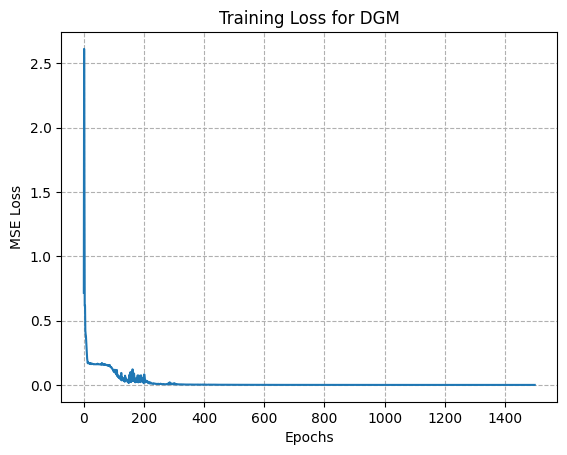

In [60]:
# Plot the losses
plt.plot(range(epochs), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss for DGM')
plt.grid(ls='--')
plt.show()

## Exercise 4

In [45]:
class ValueFunction(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ValueFunction, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim) 
        self.activation = nn.Tanh()

    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        hidden2 = self.activation(self.fc2(hidden1))
        hidden3 = self.activation(self.fc3(hidden2)) 
        output = self.fc4(hidden3)
        return output

class ControlFunction(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ControlFunction, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim) 
        self.activation = nn.Tanh()
    
    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        hidden2 = self.activation(self.fc2(hidden1))
        hidden3 = self.activation(self.fc3(hidden2)) 
        output = self.fc4(hidden3)
        return output


In [46]:
class PDE_PIA:
    def __init__(self, net_val, net_act, T, sigma, H, M, C, D, R):
        """
        Initializes the PDE solver with given networks and parameters.

        Args:
        - net_val (torch.nn.Module): Value function approximation network
        - net_act (torch.nn.Module): Control function approximation network
        - T (torch.Tensor): Final time value
        - sigma (torch.Tensor): State-dependent diffusion matrix
        - H (torch.Tensor): Weight matrix H
        - M (torch.Tensor): Weight matrix M
        - C (torch.Tensor): Weight matrix C
        - D (torch.Tensor): Weight matrix D
        - R (torch.Tensor): Weight matrix R
        """
        self.net_val = net_val
        self.net_act = net_act
        self.T = T
        self.sigma = sigma
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
    
    def pde_residual(self, t, x):
        """
        Computes the residual of the PDE equation.

        Args:
        - t (torch.Tensor): Time tensor
        - x (torch.Tensor): State tensor

        Returns:
        - pde_res (torch.Tensor): PDE residual tensor
        """
        t.requires_grad_(True)
        x.requires_grad_(True)
        
        u = self.net_val(t, x)  
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Compute the trace term
        trace_term = 0.5 * torch.trace(torch.matmul(self.sigma, self.sigma.T)) * u_xx.sum(dim=1, keepdim=True)
        t1 = (u_x @ self.H @ x.T).sum(dim=1).unsqueeze(1)
        t2 = (u_x @ (self.M @ self.net_act(t, x).T)).sum(dim=1, keepdim=True)
        t3 = (x @ self.C @ x.T).sum(dim=1).unsqueeze(1)
        t4 = (self.net_act(t, x) @ self.D @ self.net_act(t, x).T).sum(dim=1, keepdim=True)
        
        pde_res = u_t + trace_term + t1 + t2 + t3 + t4

        return pde_res

    def boundary_condition(self, x):
        """
        Computes the boundary condition term.

        Args:
        - x (torch.Tensor): State tensor

        Returns:
        - boundary_res (torch.Tensor): Boundary condition residual tensor
        """
        T = torch.full_like(x[:, :1], self.T.item())
        u_final = self.net_val(T, x)
        x = x.unsqueeze(1).detach()
        cond = torch.matmul(x, torch.matmul(self.R, x.reshape(-1, 2, 1))).reshape(-1, 1)
        return u_final - cond

    def loss_function(self, t_train, x_train):
        """
        Computes the total loss function.

        Args:
        - t_train (torch.Tensor): Time training data
        - x_train (torch.Tensor): State training data

        Returns:
        - loss (torch.Tensor): Total loss tensor
        """
        pde_residual = self.pde_residual(t_train, x_train)
        boundary_res = self.boundary_condition(x_train)
        
        pde_loss = F.mse_loss(pde_residual, torch.zeros_like(pde_residual))
        boundary_loss = F.mse_loss(boundary_res, torch.zeros_like(boundary_res))
        
        loss = pde_loss + boundary_loss
        
        return loss    

    def update_control_function(self, optimizer_act, t_train, x_train):
        """
        Updates the control function network by optimizing the Hamiltonian.

        Args:
        - optimizer_act (torch.optim.Optimizer): Optimizer for the control function network
        - t_train (torch.Tensor): Time training data
        - x_train (torch.Tensor): State training data

        Returns:
        - loss.item() (float): Loss value
        """
        optimizer_act.zero_grad()

        u = self.net_val(t_train, x_train)
        u_x = torch.autograd.grad(u, x_train, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        
        h1 = (u_x @ self.H @ x_train.T)
        h2 = u_x @ self.M @ self.net_act(t_train, x_train).T
        h3 = x_train @ self.C @ x_train.T
        h4 = self.net_act(t_train, x_train) @ self.D @ self.net_act(t_train, x_train).T

        hamiltonian = h1 + h2 + h3 + h4

        loss = torch.mean(hamiltonian)

        loss.backward()
        optimizer_act.step()

        return loss.item()

In [47]:
def policy_iteration(net_val, net_act, pde, t_train, x_train, epochs_val, epochs_act, lr_val, lr_act, lr_decay_epochs, lr_decay_factor):
    """
    Perform policy iteration to update the value and control functions.

    Args:
    - net_val (torch.nn.Module): Value function network
    - net_act (torch.nn.Module): Control function network
    - pde (PDE_PIA): PDE solver object
    - t_train (torch.Tensor): Time training data
    - x_train (torch.Tensor): State training data
    - epochs_val (int): Number of epochs for value function updates
    - epochs_act (int): Number of epochs for control function updates
    - lr_val (float): Initial learning rate for value function optimizer
    - lr_act (float): Initial learning rate for control function optimizer
    - lr_decay_epochs (int): Number of epochs before decaying learning rate
    - lr_decay_factor (float): Factor by which to decay learning rate

    Returns:
    - losses_val (list): List of value function losses over epochs
    - losses_act (list): List of control function losses over epochs
    """
    optimizer_val = optim.Adam(net_val.parameters(), lr=lr_val)
    optimizer_act = optim.Adam(net_act.parameters(), lr=lr_act)
    
    scheduler_val = StepLR(optimizer_val, step_size=lr_decay_epochs, gamma=lr_decay_factor)
    scheduler_act = StepLR(optimizer_act, step_size=lr_decay_epochs, gamma=lr_decay_factor)
    losses_val = []
    losses_act = []

    print(f"Value Function Update\n---------------------")
    for epoch in range(epochs_val):
        optimizer_val.zero_grad()
        loss_val = pde.loss_function(t_train, x_train)  # Compute total loss for value function
        loss_val.backward()  # Backpropagate gradients
        torch_utils.clip_grad_norm_(net_val.parameters(), 1.0)  # Clip gradients to prevent exploding gradients
        optimizer_val.step()  # Update value function parameters
        scheduler_val.step()  # Adjust learning rate
        losses_val.append(loss_val.item())  # Store the loss value
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss = {loss_val.item()}')

    print(f"-----------------------\nControl Function Update\n-----------------------")
    for epoch in range(epochs_act):
        loss_act = pde.update_control_function(optimizer_act, t_train, x_train)  # Update control function
        scheduler_act.step()  # Adjust learning rate
        losses_act.append(loss_act)  # Store the loss value
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss = {loss_act}')

    return losses_val, losses_act


In [59]:
# Initialize value function and control function networks
net_val = ValueFunction(input_dim=3, hidden_dim=150, output_dim=1)
net_act = ControlFunction(input_dim=3, hidden_dim=150, output_dim=2)

T = torch.tensor([1], dtype=torch.float32)
# Initialize PDE solver with networks and other parameters
pde = PDE_PIA(net_val, net_act, T, sigma, H, M, C, D, R)

# Generate training data (sampled from [0, T) x R^2)
t_train = torch.rand(num_samples, 1) * pde.T
x_train = torch.rand(num_samples, 2)

# Hyperparameters for learning rate scheduler
lr_decay_epochs = 200
lr_decay_factor = 0.2

# Run policy iteration algorithm with learning rate scheduler
losses_val, losses_act = policy_iteration(net_val, net_act, pde, t_train, x_train, 
                                          epochs_val=1500, epochs_act=1500, lr_val=1e-2, lr_act=1e-2, 
                                          lr_decay_epochs=lr_decay_epochs, lr_decay_factor=lr_decay_factor)


Value Function Update
---------------------
Epoch 0, Loss = 61.96691131591797


Epoch 100, Loss = 1.0964813232421875
Epoch 200, Loss = 0.38341590762138367
Epoch 300, Loss = 0.057675838470458984
Epoch 400, Loss = 0.050061069428920746
Epoch 500, Loss = 0.023515189066529274
Epoch 600, Loss = 0.016099778935313225
Epoch 700, Loss = 0.014942601323127747
Epoch 800, Loss = 0.013800503686070442
Epoch 900, Loss = 0.013569940812885761
Epoch 1000, Loss = 0.013328338973224163
Epoch 1100, Loss = 0.01327736396342516
Epoch 1200, Loss = 0.01322352234274149
Epoch 1300, Loss = 0.013212133198976517
Epoch 1400, Loss = 0.013200126588344574
-----------------------
Control Function Update
-----------------------
Epoch 0, Loss = -0.05381803587079048
Epoch 100, Loss = -15.264248847961426
Epoch 200, Loss = -15.264251708984375
Epoch 300, Loss = -15.264251708984375
Epoch 400, Loss = -15.264251708984375
Epoch 500, Loss = -15.264251708984375
Epoch 600, Loss = -15.264251708984375
Epoch 700, Loss = -15.264251708984375
Epoch 800, Loss = -15.264251708984375
Epoch 900, Loss = -15.264251708984375
Epo

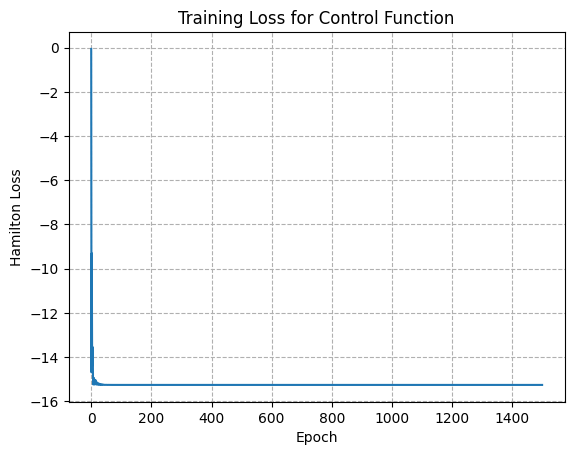

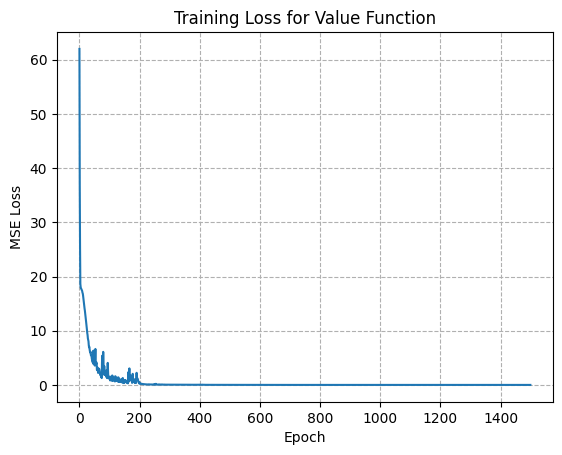

In [60]:
# Plotting the training losses
plt.plot(range(len(losses_act)), losses_act, label='Control Function Loss')
plt.xlabel('Epoch')
plt.ylabel('Hamilton Loss')
plt.title('Training Loss for Control Function')
plt.grid(linestyle='dashed')
plt.show()

plt.plot(range(len(losses_val)), losses_val, label='Value Function Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss for Value Function')
plt.grid(linestyle='dashed')
plt.show()